In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 10)


First, upload your `cifar-10-python.tar.gz` file to your Colab environment. You can do this by clicking the folder icon in the left sidebar, then the upload icon.

In [ ]:
import os
import tarfile
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar10_from_tar(tar_path):
    """Loads CIFAR-10 dataset from a .tar.gz file."""
    train_batches = []
    train_labels = []
    test_batches = []
    test_labels = []

    with tarfile.open(tar_path, 'r:gz') as tar:
        for member in tar.getmembers():
            if member.name.startswith('cifar-10-batches-py/data_batch_') and member.isfile():
                f = tar.extractfile(member)
                if f:
                    data_dict = unpickle(f)
                    train_batches.append(data_dict[b'data'])
                    train_labels.extend(data_dict[b'labels'])
            elif member.name == 'cifar-10-batches-py/test_batch' and member.isfile():
                 f = tar.extractfile(member)
                 if f:
                     data_dict = unpickle(f)
                     test_batches.append(data_dict[b'data'])
                     test_labels.extend(data_dict[b'labels'])

    x_train = np.concatenate(train_batches).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_train = np.array(train_labels)
    x_test = np.concatenate(test_batches).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    y_test = np.array(test_labels)

    return (x_train, y_train), (x_test, y_test)

# Replace '/path/to/your/cifar-10-python.tar.gz' with the actual path to your uploaded file
cifar10_tar_path = 'cifar-10-python.tar.gz' # Assuming the file is in the Colab environment root
(x_train, y_train), (x_test, y_test) = load_cifar10_from_tar(cifar10_tar_path)

# The rest of your data preprocessing remains the same
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
#Load pretrained CNN and freeze lower layers

IMG_SIZE = 96 #resizing CIFAR images to fit MV2

x_train_resized = tf.image.resize(x_train, (IMG_SIZE, IMG_SIZE))
x_test_resized = tf.image.resize(x_test, (IMG_SIZE, IMG_SIZE))

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

#freeze all convolutional layers
for layer in base_model.layers:
  layer.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#custom classifier layers
x = base_model.output
x= GlobalAveragePooling2D()(x) # Convert feature maps to vector
x = Dense(1024, activation='relu')(x) #trainable dense layer
x = Dropout(0.5)(x) # dropout for regularization
predictions = Dense(10, activation='softmax')(x)

#full model
model = Model(inputs=base_model.input, outputs=predictions)

#compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 48, 48,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 48, 48,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 48, 48,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 48, 48,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 48, 48,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 48, 48,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 48, 48,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 48, 48,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 49, 49,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 24, 24,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 24, 24,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 24, 24,    │      2,304 │ block_1_depthwis

 Total params: 3,579,978 (13.66 MB)

 Trainable params: 1,321,994 (5.04 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(x_train_resized, y_train, batch_size=64, epochs=3, validation_data=(x_test_resized, y_test)) #inc epochs

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 432s 542ms/step - accuracy: 0.6767 - loss: 0.9741 - val_accuracy: 0.7914 - val_loss: 0.6000
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 406s 519ms/step - accuracy: 0.7707 - loss: 0.6537 - val_accuracy: 0.8074 - val_loss: 0.5615
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 416s 533ms/step - accuracy: 0.7935 - loss: 0.5957 - val_accuracy: 0.8097 - val_loss: 0.5487


In [ ]:
#fine tune hyperparameters
#unfreeze the last 20 layers for finetuining
for layer in base_model.layers[-20:]:
  layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
history_fine_tune = model.fit(x_train_resized, y_train, batch_size=64, epochs=3, validation_data=(x_test_resized, y_test), verbose=1)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 610s 761ms/step - accuracy: 0.7620 - loss: 0.7201 - val_accuracy: 0.7522 - val_loss: 0.7941
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 591s 756ms/step - accuracy: 0.8749 - loss: 0.3649 - val_accuracy: 0.7851 - val_loss: 0.7364
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 617s 751ms/step - accuracy: 0.9098 - loss: 0.2592 - val_accuracy: 0.8092 - val_loss: 0.6613


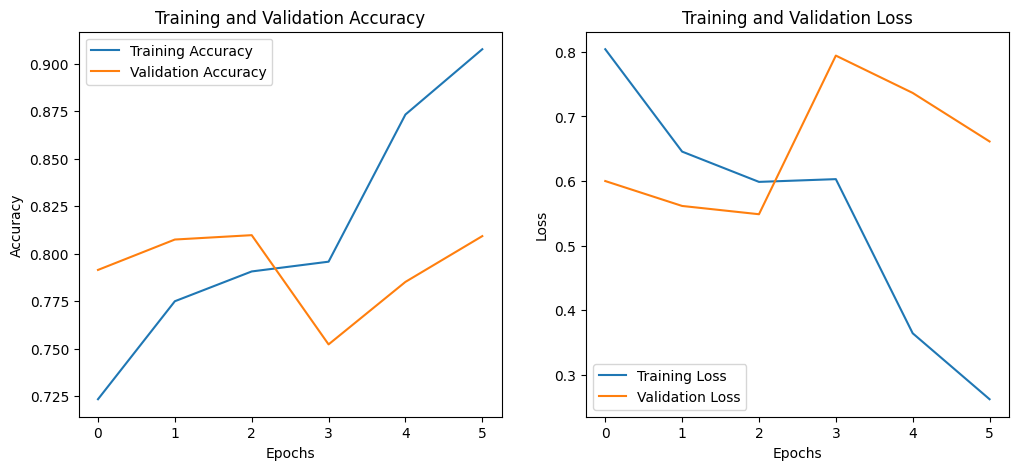

In [ ]:
#training and validation plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()